In [1]:
from importlib import reload
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import analyze
import raybay

In [2]:
# Load treatment plan results
sample = np.load('sample/res_linear_dummy_minimize.pkl', allow_pickle=True)

In [3]:
sample.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,Chestwall_L,MaxDvh,AtMost,3000,2.04
1,D2cm,MaxDose,AtMost,2400,NaN
2,Esophagus,MaxDvh,AtMost,1880,16.91
3,Lungs,MaxDvh,AtMost,1160,29.19
4,Lungs,MaxDvh,AtMost,1240,19.46
5,PTV,MinDvh,AtLeast,4800,95.00
6,PTV,MaxDose,AtMost,8000,NaN
7,Rib,MaxDvh,AtMost,3200,0.27
8,Rib,MaxDose,AtMost,4000,NaN
9,SpinalCanal,MaxDvh,AtMost,1360,2.30


In [4]:
sample.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,Chestwall_L,MaxDvh,"[0,3000]",2.04,NaN,1
1,D2cm,MaxDose,"[0,2400]",0.00,NaN,1
2,Esophagus,MaxDvh,"[0,1880]",16.91,NaN,1
3,Lungs,MaxDvh,"[0,1160]",29.19,NaN,1
4,Lungs,MaxDvh,"[0,1240]",19.46,NaN,1
5,PTV,MinDvh,4800,95.00,NaN,1
6,PTV,MaxDose,"[4801,8000]",0.00,NaN,1
7,Rib,MaxDvh,"[0,3200]",0.27,NaN,1
8,Rib,MaxDose,"[0,4000]",0.00,NaN,1
9,SpinalCanal,MaxDvh,"[0,1360]",2.30,NaN,1


In [20]:
# Filter by flag = 0
idx_0 = np.where(np.array(sample.flag_list) == 0)[0]
goal_dict = {ii: np.array(sample.goal_dict[ii])[idx_0] for ii in sample.goal_dict}
par_list = np.array(sample.opt_result.x_iters)[idx_0,:]

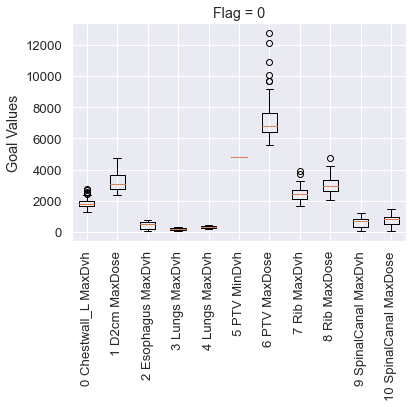

In [21]:
analyze.boxplot(sample.goal_df, goal_dict, 'goals', title='Flag = 0')

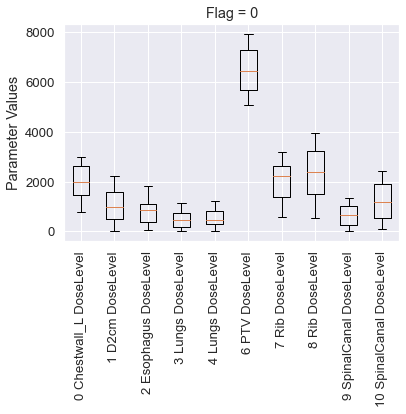

In [22]:
analyze.boxplot(sample.func_df, par_list, 'pars', title='Flag = 0')

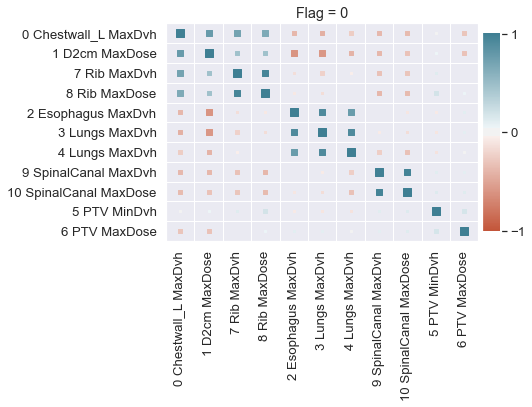

In [23]:
analyze.corrplot(sample.goal_df, goal_dict, title='Flag = 0')

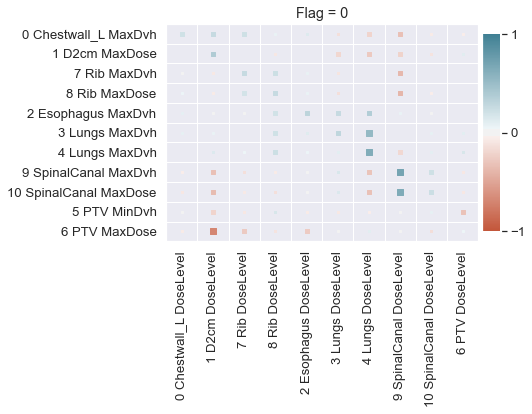

In [24]:
analyze.corrplot(sample.goal_df, goal_dict, sample.func_df, par_list, title='Flag = 0')

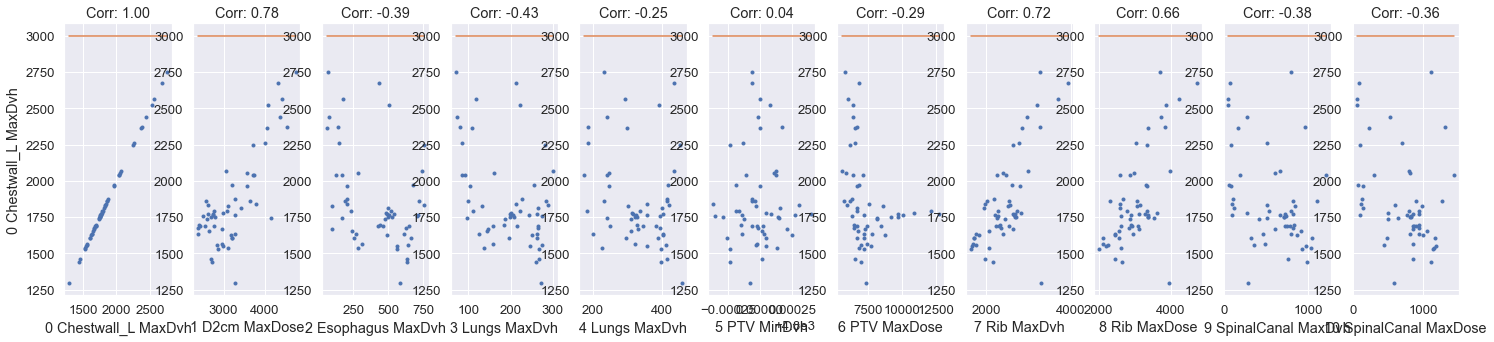

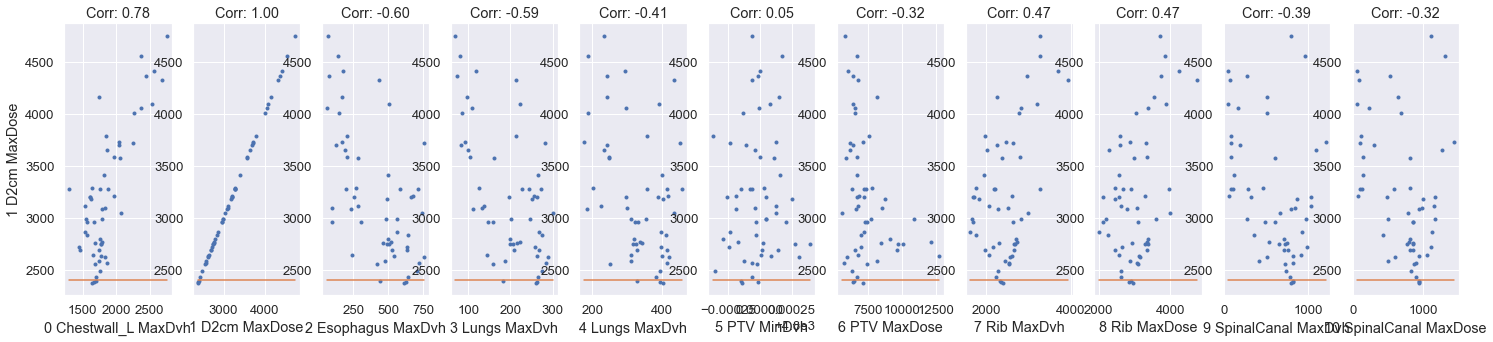

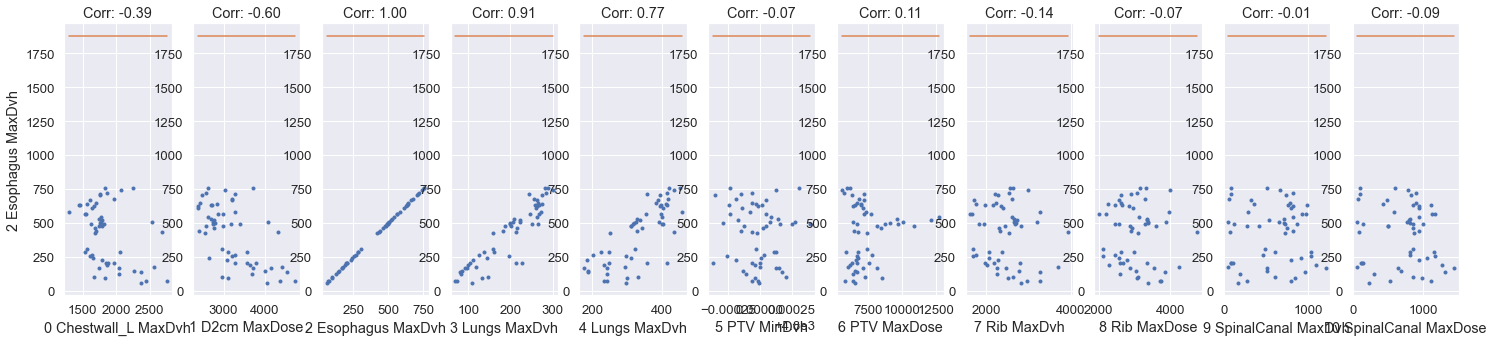

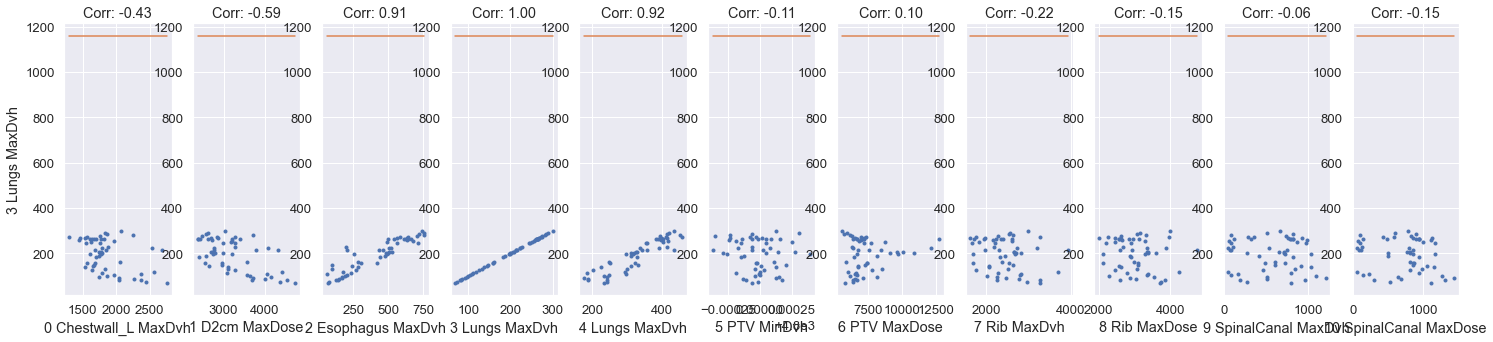

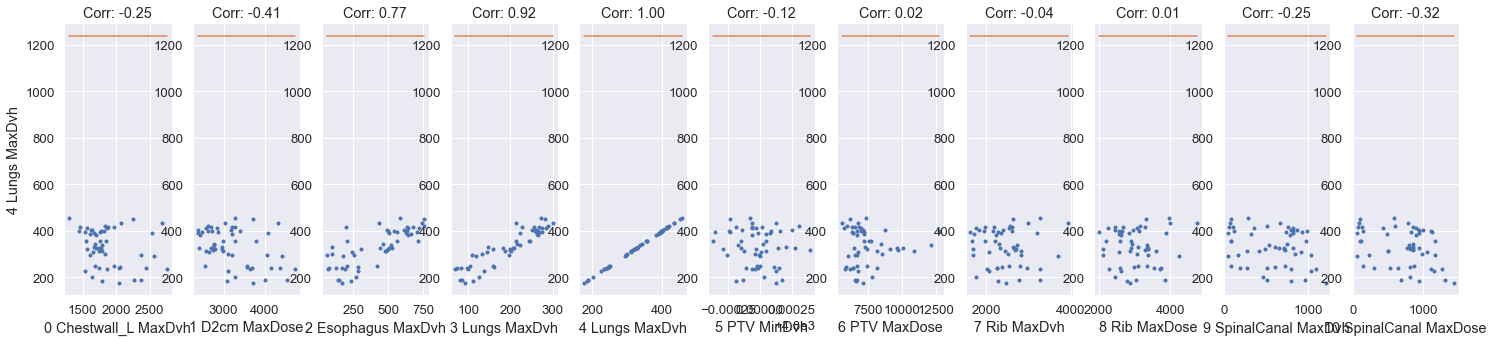

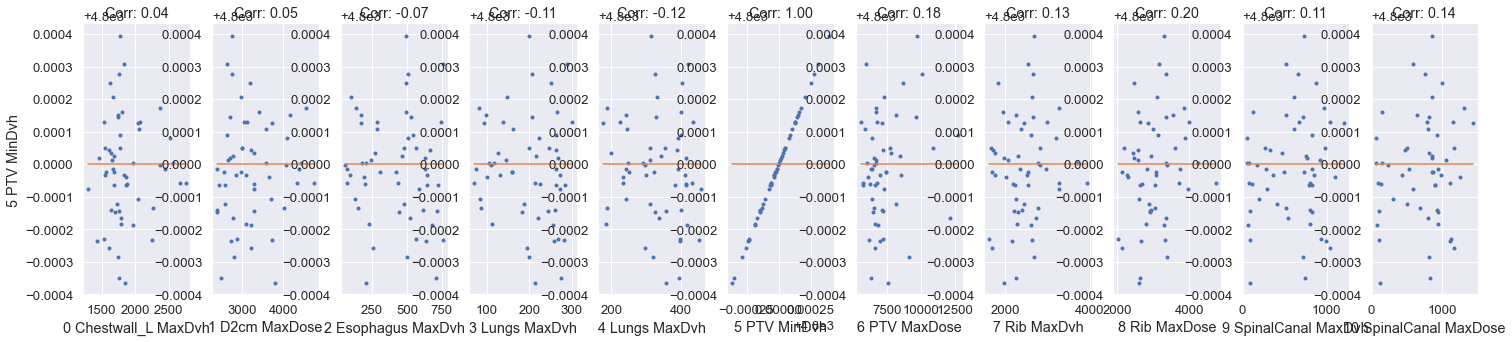

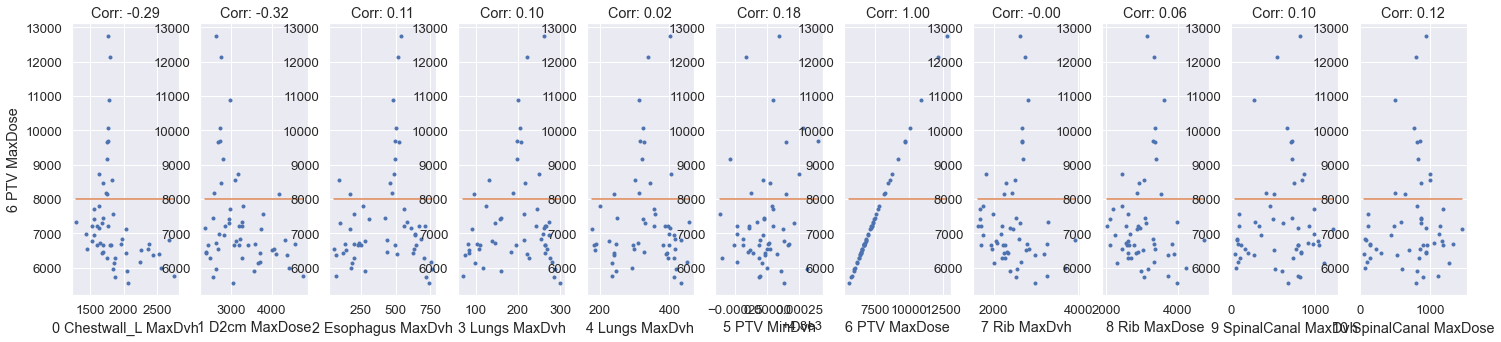

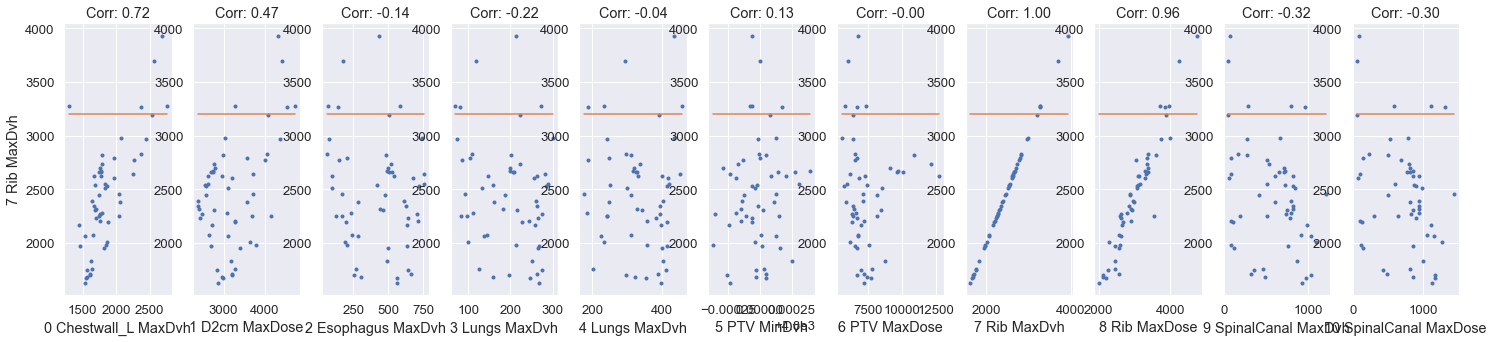

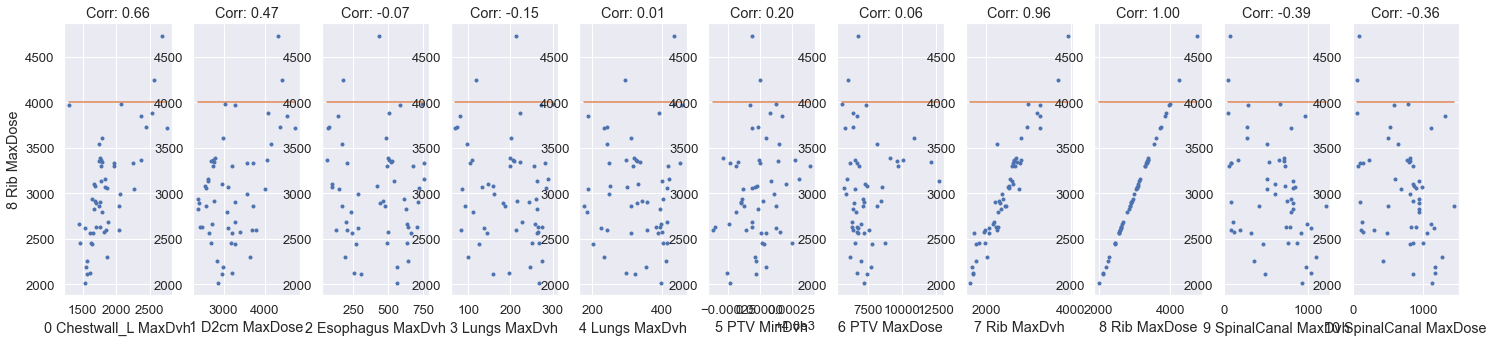

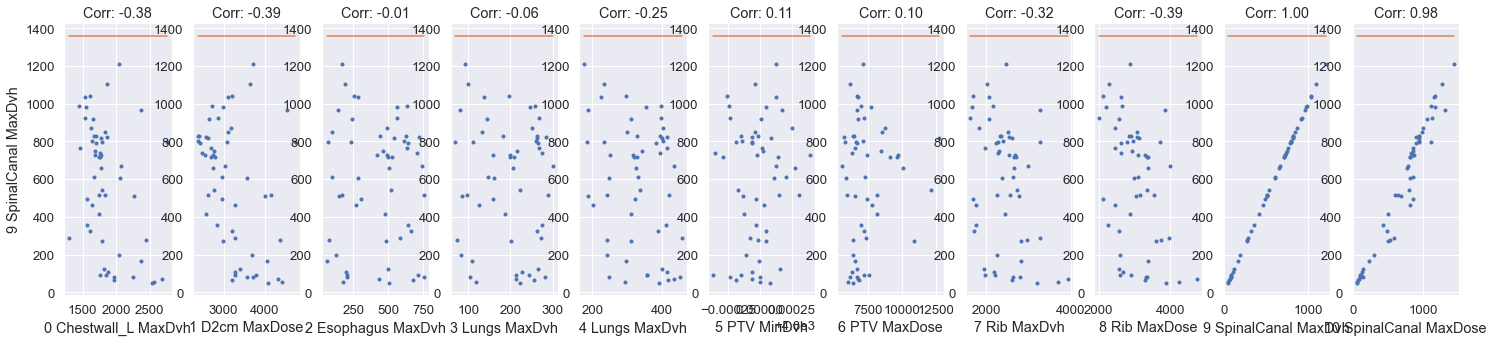

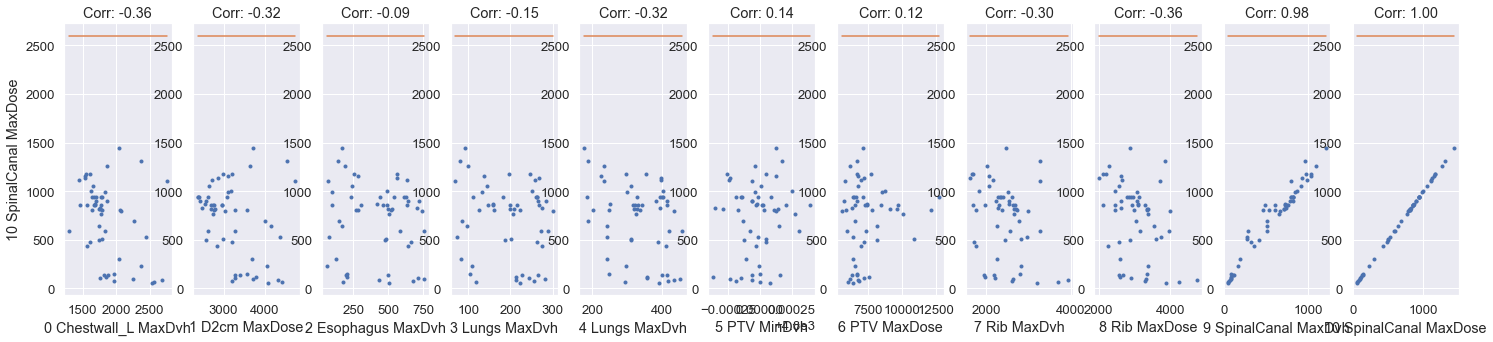

In [25]:
analyze.scatterplot(sample.goal_df, goal_dict)

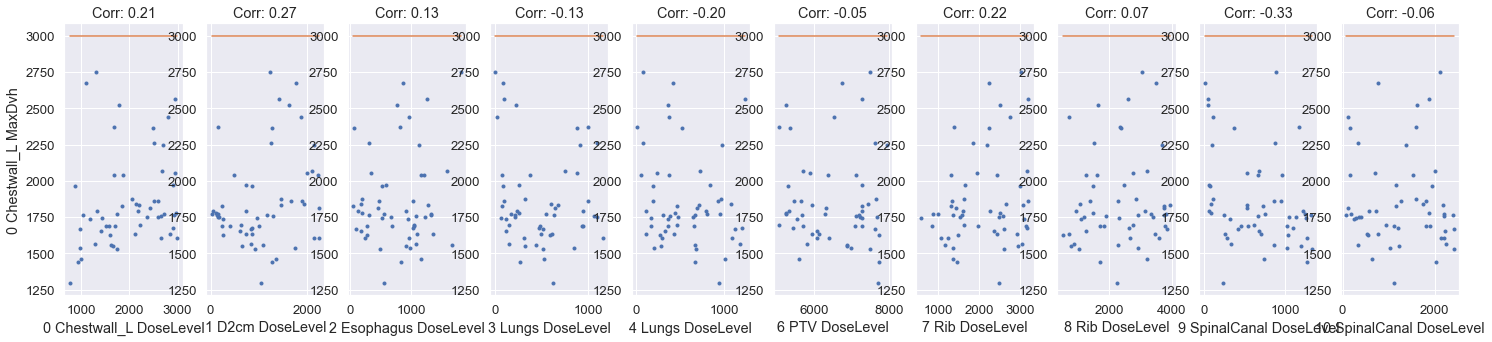

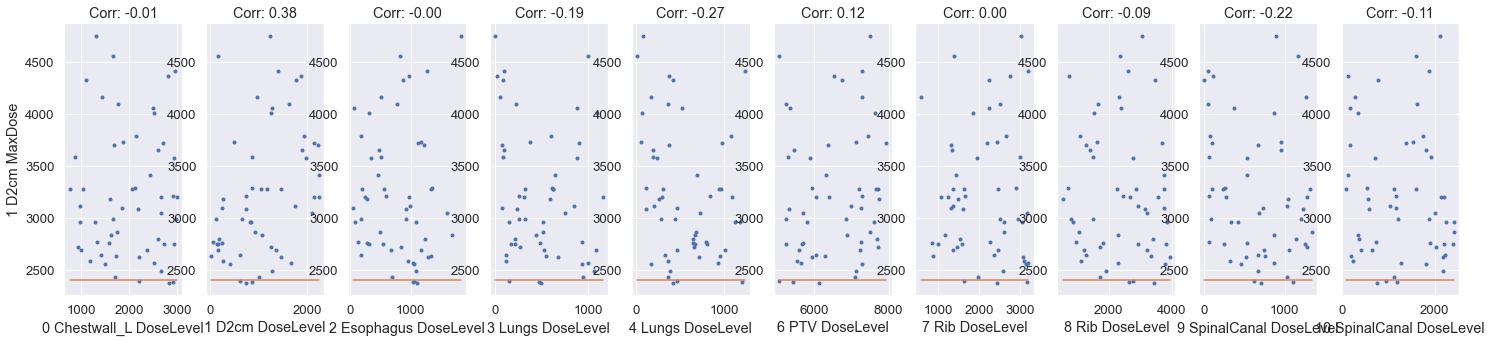

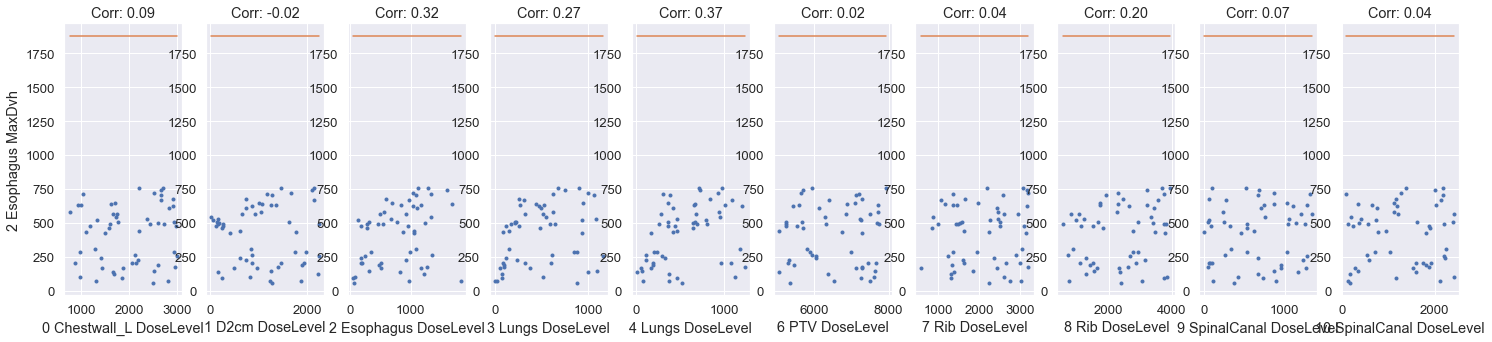

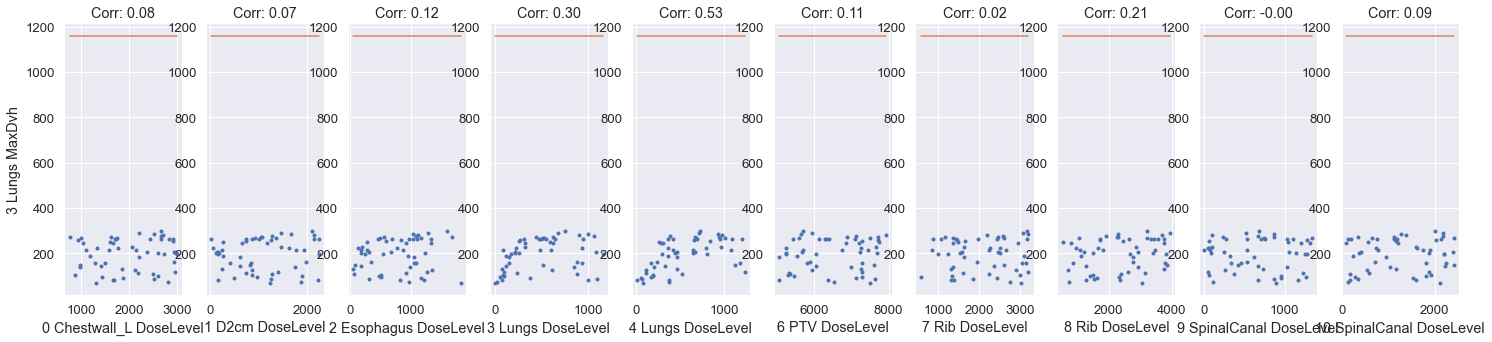

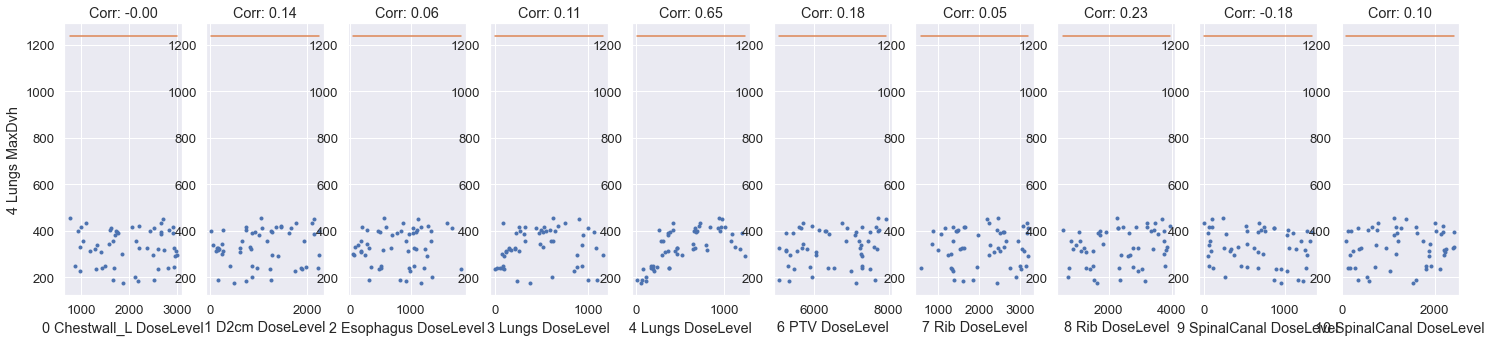

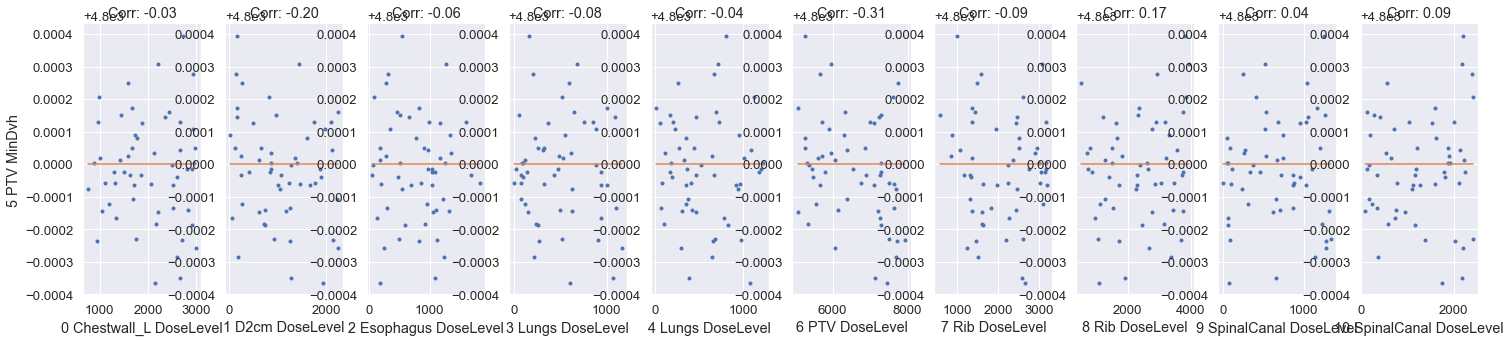

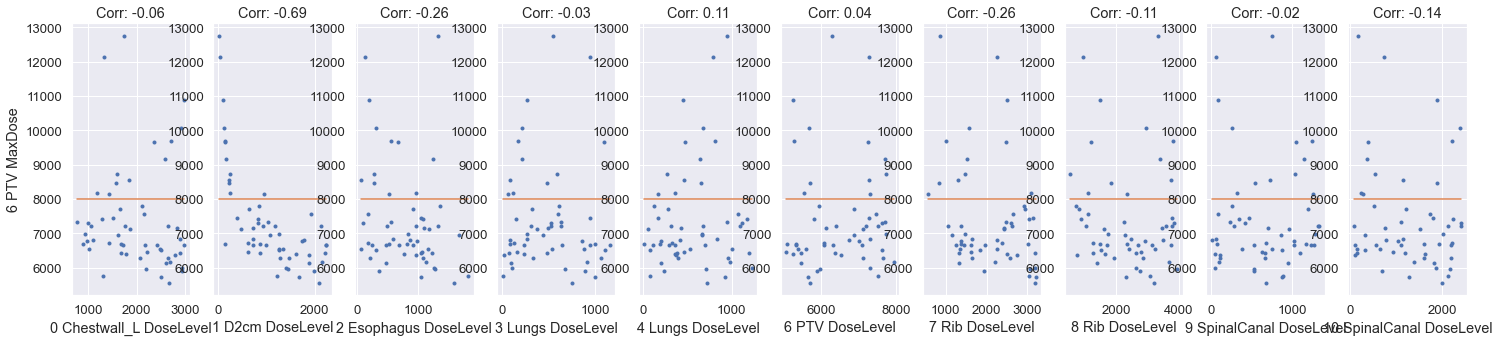

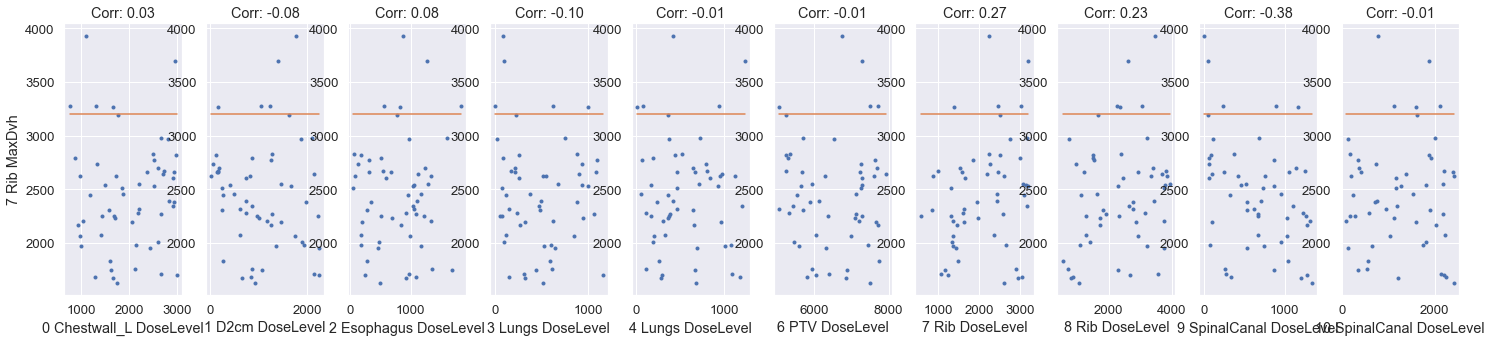

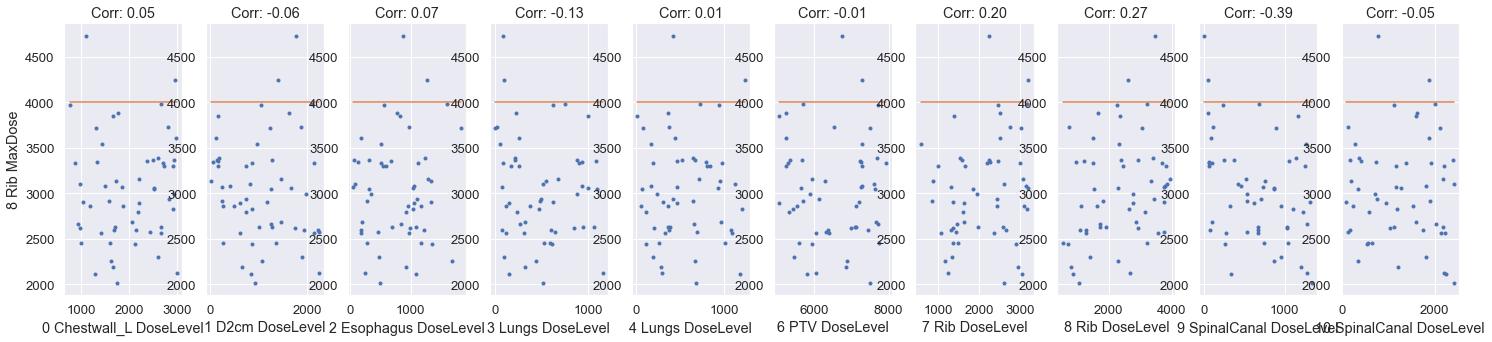

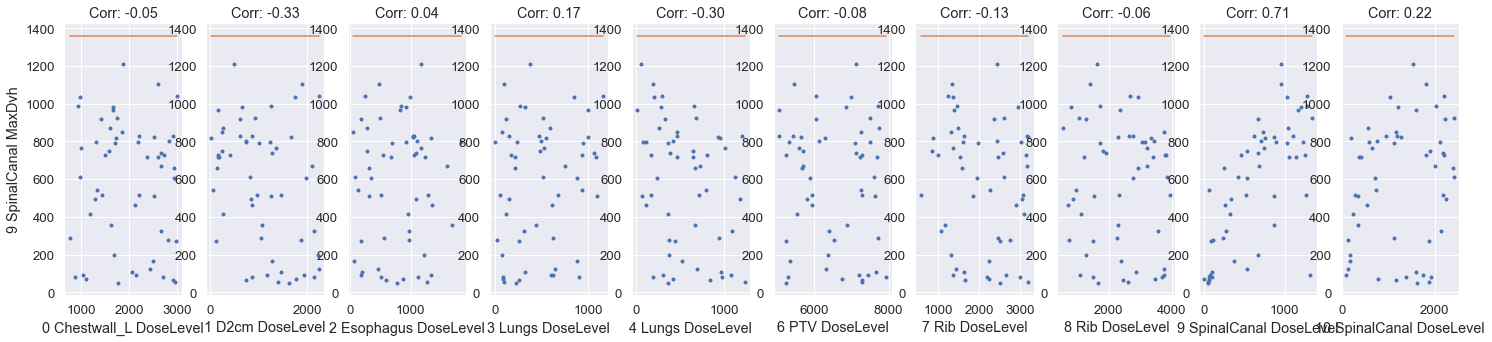

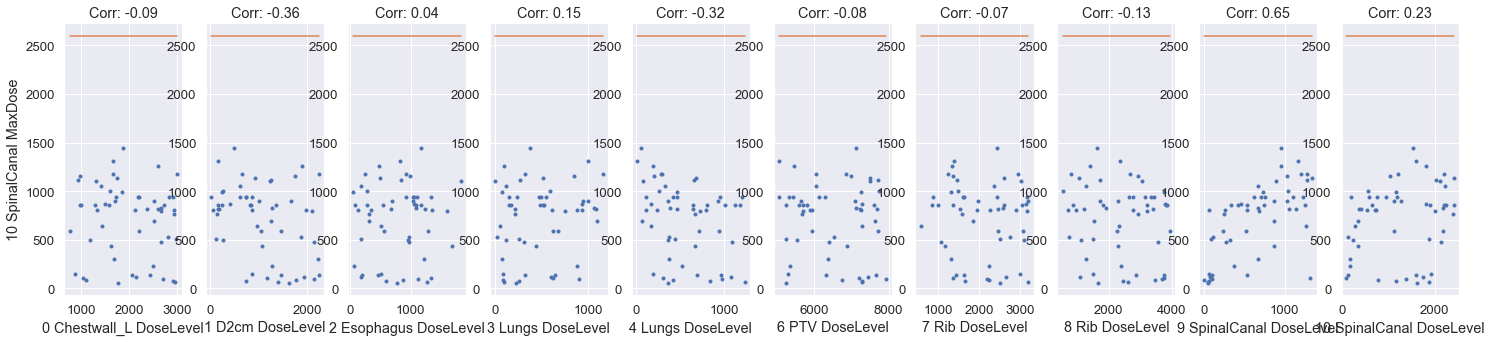

In [26]:
analyze.scatterplot(sample.goal_df, goal_dict, sample.func_df, par_list)

In [130]:
# Potential Story:
# * run default plan, decide which goals need to be improved
# * choose parameters based on which goals need to be improved
# * go from 0-max
# * do grid search, then evaluate for each function type?
# * 

In [14]:
# Experiment with different utilities

In [29]:
def get_utility(goal_df, goal_dict):
    util_vec = np.zeros(len(goal_dict[0]))
    for ii in range(len(util_vec)):
        for index, row in goal_df.iterrows():
            util_vec[ii] += row['Weight']*raybay.get_term(goal_dict[index][ii],
                row['AcceptanceLevel'], row['Type'], row['Shape'])
    return util_vec

In [30]:
class Result:
    def __init__(self, goal_df, goal_dict, weights, shapes):
        func_vals = np.zeros(len(goal_dict[0]))
        for ii in range(len(func_vals)):
            for index, row in goal_df.iterrows():
                func_vals[ii] -= weights[index]*raybay.get_term(
                    goal_dict[index][ii],
                    row['AcceptanceLevel'],
                    row['Type'],
                    shapes[index])
        self.opt_result = OptResult(func_vals)
        self.goal_dict = goal_dict       
        
class OptResult:
    def __init__(self,func_vals):
        self.func_vals = func_vals

In [31]:
weights = [1]*11
shapes_l = ['linear']*11
l = Result(sample.goal_df, sample.goal_dict, weights, shapes_l)

In [32]:
shapes_q = ['linear_quadratic']*11
lq = Result(sample.goal_df, sample.goal_dict, weights, shapes_q)

In [33]:
weights_r = [1]*11
weights_r[7] = 0.1
weights_r[8] = 0.1
lq_wr = Result(sample.goal_df, sample.goal_dict, weights_r, shapes_q)

In [34]:
l_wr = Result(sample.goal_df, sample.goal_dict, weights_r, shapes_l)

In [35]:
shapes_r = ['linear_quadratic']*11
shapes_r[7] = 'linear'
shapes_r[8] = 'linear'
lq_sr = Result(sample.goal_df, sample.goal_dict, weights, shapes_r)

In [36]:
approved = np.load('approved/res.pkl', allow_pickle=True)
default = np.load('default/res.pkl', allow_pickle=True)
res_dict = {
    'Approved': approved,
    'Default': default,
    'linear' : l,
    'linear rib 0.1': l_wr,
    'linear-quadratic': lq,
    'linear-quadratic rib 0.1': lq_wr,
    'linear-quadratic rib lin': lq_sr
}

In [38]:
reload(analyze)

<module 'analyze' from '../../src/analyze.py'>

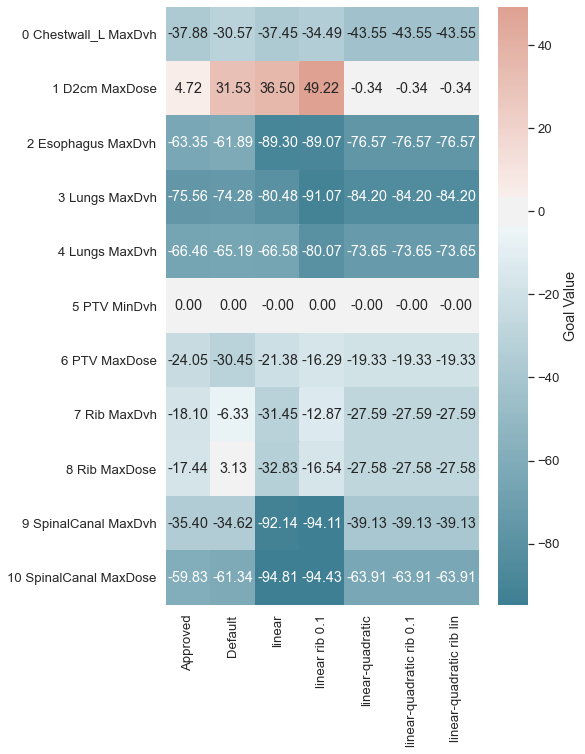

In [39]:
analyze.goalplot(sample.goal_df, res_dict)
# rib isn't too hard to meet, so don't see much diff

# not sure this is a good prediction of the actual values though

Text(0.5, 0, 'Rib MaxDose')

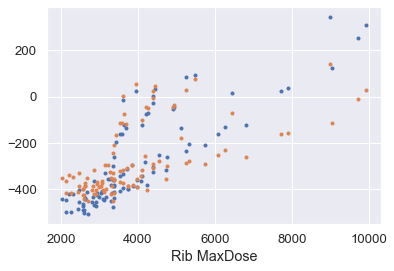

In [130]:
x_iters = np.array(sample.opt_result.x_iters)
plt.plot(sample.goal_dict[8], l.opt_result.func_vals, '.')
plt.plot(sample.goal_dict[8], l_wr.opt_result.func_vals, '.')
plt.xlabel('Rib MaxDose')

(2000.0, 5000.0)

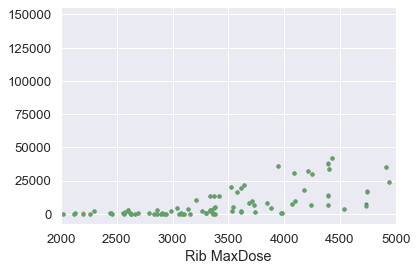

In [135]:
plt.plot(sample.goal_dict[8], lq.opt_result.func_vals, '.')
plt.plot(sample.goal_dict[8], lq_wr.opt_result.func_vals, '.')
plt.plot(sample.goal_dict[8], lq_sr.opt_result.func_vals, '.')
plt.xlabel('Rib MaxDose')
plt.xlim([2000, 5000])

(200.0, 900.0)

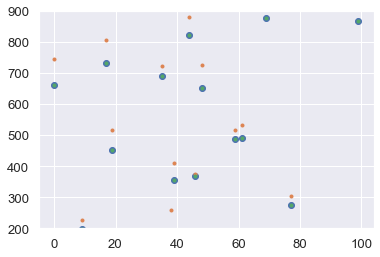

In [102]:
plt.plot(lq.opt_result.func_vals, 'o')
plt.plot(lq_wr.opt_result.func_vals, '.')
plt.plot(lq_sr.opt_result.func_vals, '.')
plt.ylim([200, 900])

(900.0, 1600.0)

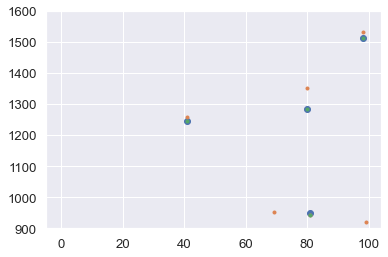

In [103]:
plt.plot(lq.opt_result.func_vals, 'o')
plt.plot(lq_wr.opt_result.func_vals, '.')
plt.plot(lq_sr.opt_result.func_vals, '.')
plt.ylim([900, 1600])

(1600.0, 2300.0)

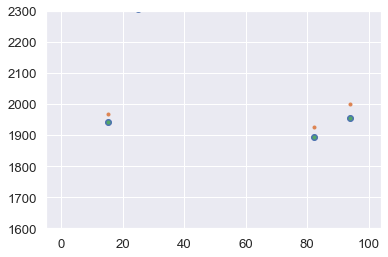

In [104]:
plt.plot(lq.opt_result.func_vals, 'o')
plt.plot(lq_wr.opt_result.func_vals, '.')
plt.plot(lq_sr.opt_result.func_vals, '.')
plt.ylim([1600, 2300])

In [136]:
# If you think about it, the linear utilities vs. linear-quadratic utilities only matter
# for the goals that are likely to be violated (D2cm, Rib, sometimes ChestWall...)
# so how do you weight things???

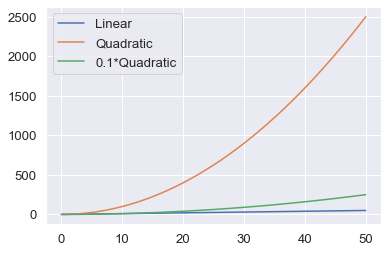

In [140]:
x = np.linspace(0, 50)
plt.plot(x, x)
plt.plot(x, x**2)
plt.plot(x, 0.1*x**2)
plt.legend(['Linear', 'Quadratic', '0.1*Quadratic'])

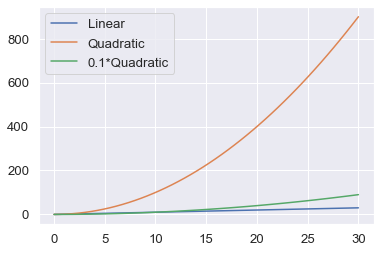

In [141]:
x = np.linspace(0, 30)
plt.plot(x, x)
plt.plot(x, x**2)
plt.plot(x, 0.1*x**2)
plt.legend(['Linear', 'Quadratic', '0.1*Quadratic'])

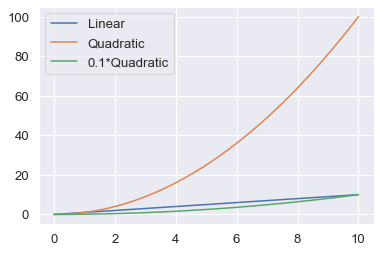

In [142]:
x = np.linspace(0, 10)
plt.plot(x, x)
plt.plot(x, x**2)
plt.plot(x, 0.1*x**2)
plt.legend(['Linear', 'Quadratic', '0.1*Quadratic'])

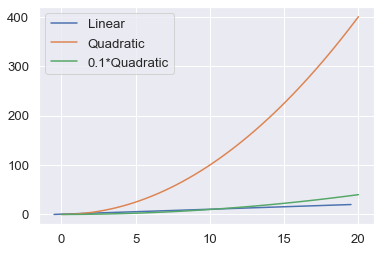

In [145]:
x = np.linspace(0, 20)
plt.plot(x-1/2, x)
plt.plot(x, x**2)
plt.plot(x, 0.1*x**2)
plt.legend(['Linear', 'Quadratic', '0.1*Quadratic'])

In [147]:
# question: multiplying by 0.1 means we don't even care about reducing it below,
# but using linear means we don't care about violating the goal
# should run with linear for ribs!

# for the first patient, the linear seems to work well, could do the grid search there
# but then maybe no, because it still doesn't meet D2cm goal
# could go grid search with linear-quadratic
# hmm, need to think about this more

# but should definitely run with linear for rib for all patients

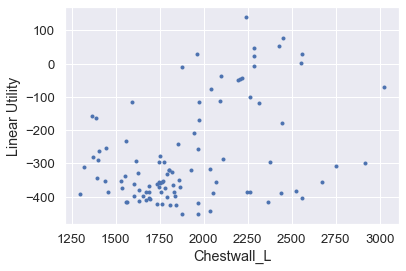

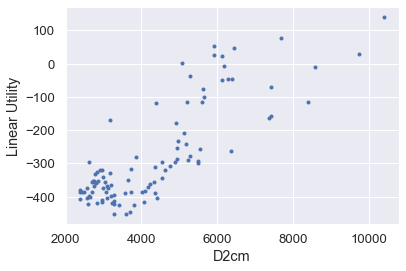

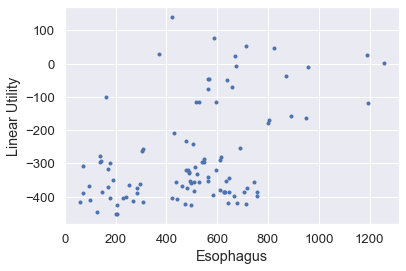

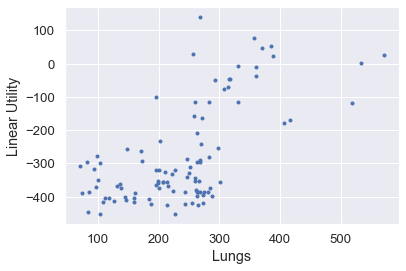

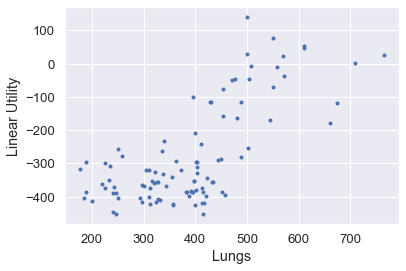

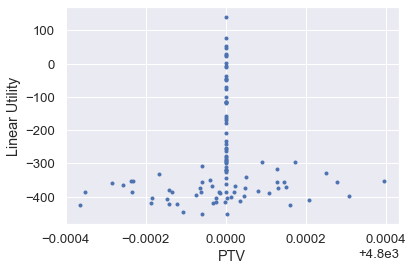

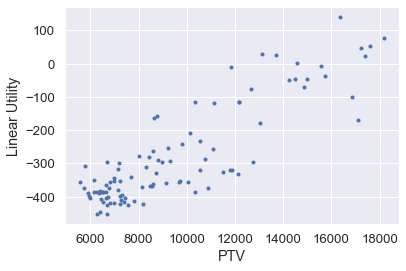

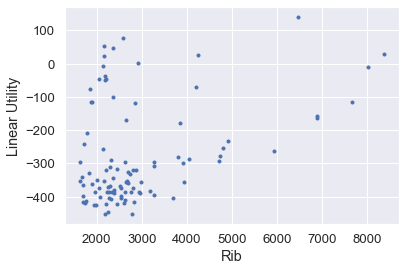

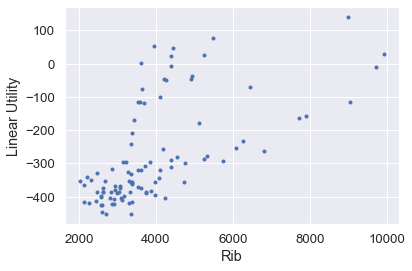

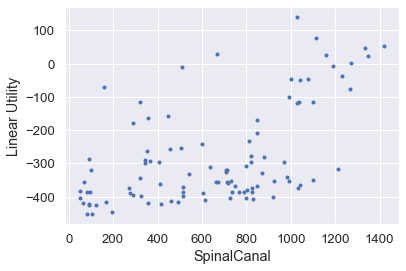

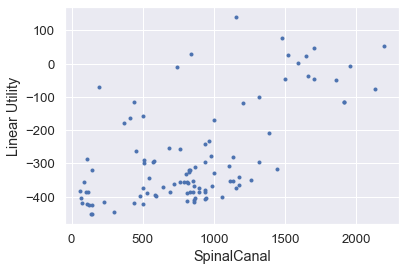

In [154]:
for goal in sample.goal_dict:
    plt.figure()
    plt.plot(sample.goal_dict[goal], l_wr.opt_result.func_vals, '.')
    plt.xlabel(sample.goal_df.iloc[goal]['Roi'])
    plt.ylabel('Linear Utility')

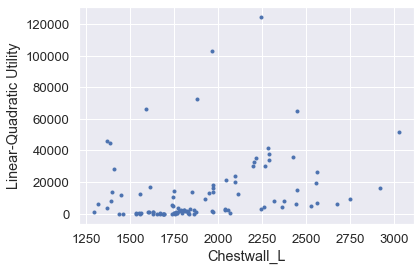

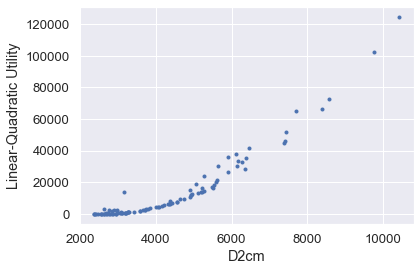

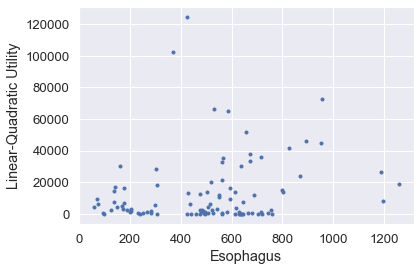

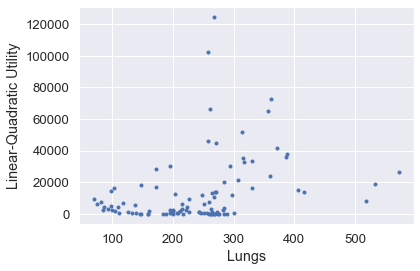

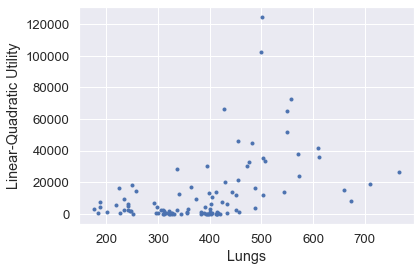

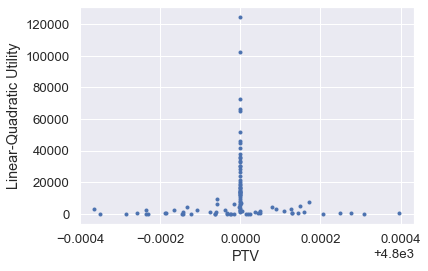

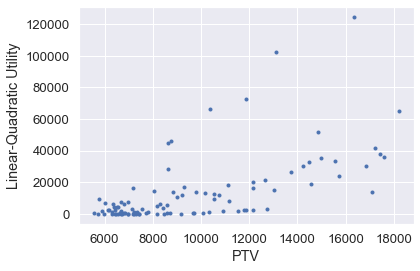

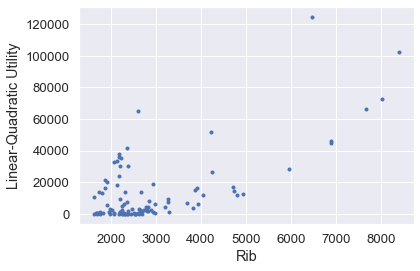

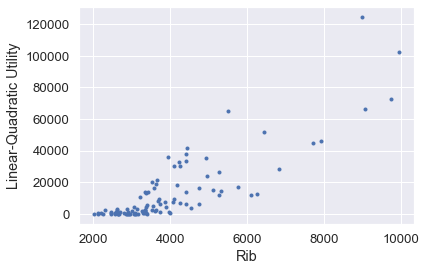

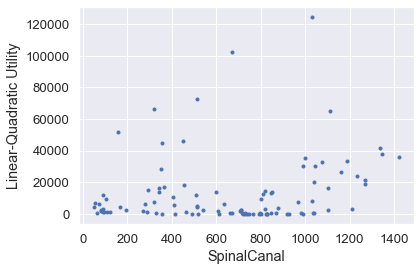

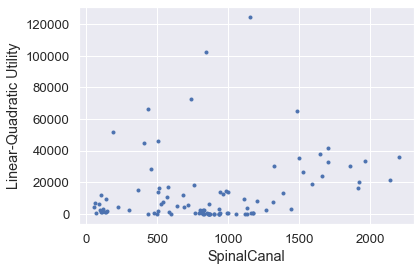

In [155]:
for goal in sample.goal_dict:
    plt.figure()
    plt.plot(sample.goal_dict[goal], lq_wr.opt_result.func_vals, '.')
    plt.xlabel(sample.goal_df.iloc[goal]['Roi'])
    plt.ylabel('Linear-Quadratic Utility')

In [ ]:
# Two questions: Which goals influence the utility? -> utility design
# Which parameters influence the goals? -> parameter choice (also correlations... reduce dim)

# filter by parameter values (can't control goal values, so why bother filtering by them?)

# TODO: Try filtering by parameter values

In [ ]:
# Today: 
# - run lin_rib for all patients
# - create sample doc for all patients (with estimates for diff utilites, compare to actual!)

In [40]:
len(sample.opt_result.x_iters)

100

<IPython.core.display.Javascript object>


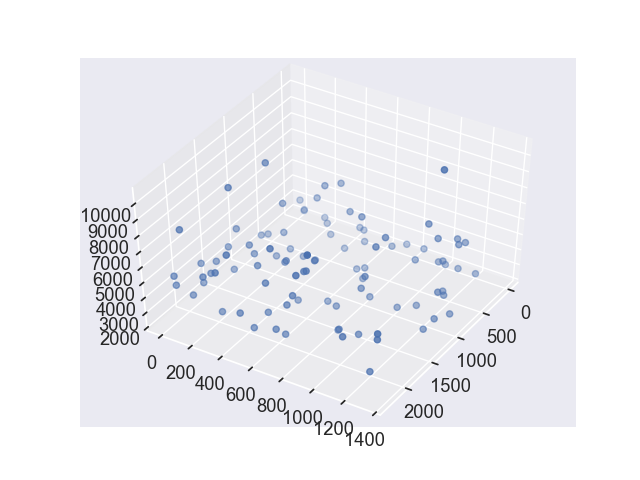

In [42]:
# Parameters vs. D2cm Goal
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([row[1] for row in sample.opt_result.x_iters], 
             [row[8] for row in sample.opt_result.x_iters], 
             sample.goal_dict[1])

<IPython.core.display.Javascript object>


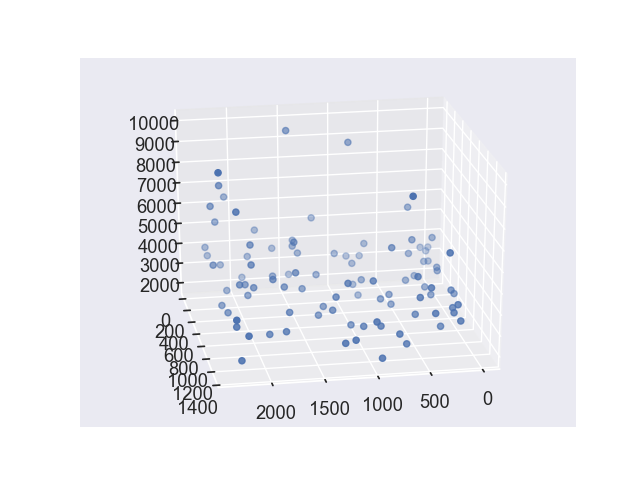

In [43]:
# Parameters vs. Rib Goal
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([row[1] for row in sample.opt_result.x_iters], 
             [row[8] for row in sample.opt_result.x_iters], 
             sample.goal_dict[8])

In [44]:
# Don't look as clean (because more paramters, can't see all dimensions, influences...)